# Boundary-value problems

As you probably know from Calculus, a boundary-value problem is a problem for an unknown $u= u(y)$ of the form 
$$\mathcal{L} u = f, \quad a < y < b,$$
where $\mathcal{L}$ is a differential operator defined on $[a,b]$ and $f = f(y)$ is a known function. For instance, consider the Poiseuille flow between two parallel plates driven by constant pressure gradient $P_l$. The problem that governs the velocity profile $u$ is
$$ \mu u_{yy} + P_l = 0, $$
subject to boundary conditions $u(a) = 0$ and $u(b) = 0$, where $b-a$ is the width of the chanel. It is clear in this case that $\displaystyle\mathcal{L} = \frac{\mathrm{d}^2}{\mathrm{d}y^2} $ and $f = -P_l/\mu$. The idea behind finding a numerical solution to the problem is, provided a discretization of operator $\mathcal{L}$ on a numerical grid $a \leq y_j \leq b$, to solve the algebraic system 
$$ (L y)_j = f_j, $$
where $L$ is an approximation to the operator $\mathcal{L}$ that includes the information from the boundary conditions and subindex $j$ indicates nodal values at $y_j$. If the problem is linear, the solution is found by simply inverting $y_j \simeq L^{-1} f_j$, given that $L$ is typically a square matrix. I will use linear examples first to get yourself familiarised with the different discretisation techniques. If the system is otherwise nonlinear, we can consider two approaches: i) apply a Newton-Raphson to the discretized system or viceversa, ii) use built-in solvers that does this process for us (although nothing prevents us from doing this for linear problems as well). More on this below.

## 1. Linear problems

### Finite differences for Poiseuille flow

In this section, we solve the boundary value problem for Poiseuille flow:

$$
0 = P_l + \mu \, u_{yy}, \quad 0 <  y< h,
$$

with the Dirichlet boundary conditions $u(0)=u(h)=0$.

The steps are as follows:

1. **Discretization:**  
   We discretize the domain $y \in [0,h]$ using a grid with spacing $\Delta y$.

2. **Finite Difference Approximation:**  
   The second derivative is approximated using the central difference scheme:
   $$
   u_{yy}(y_i) \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta y^2},
   $$
   which is valid for the interior nodes (i.e., those excluding the boundaries) and is second-order accurate. Boundary conditions need to be handled separately (see below).

4. **Matrix Formulation:**  
   With the finite difference approximation, the differential equation is rewritten in matrix form. Each interior row of the matrix represents the discretized version of the second derivative.

5. **Incorporating Boundary Conditions:**  
   The boundary conditions are imposed by replacing the rows corresponding to $y=0$ and $y=h$ with the conditions $u(0)=0$ and $u(h)=0$.

6. **Example Problem:**  
   For Poiseuille flow, the equation becomes
   $$
   \mu \, u_{yy} = -P_l,
   $$
   with the analytical solution given by
   $$
   u(y) = \frac{P_l}{2\mu} y(h-y).
   $$

The Python snippet below sets up the finite difference matrix, applies the boundary conditions via row replacement, and then solves the resulting linear system.


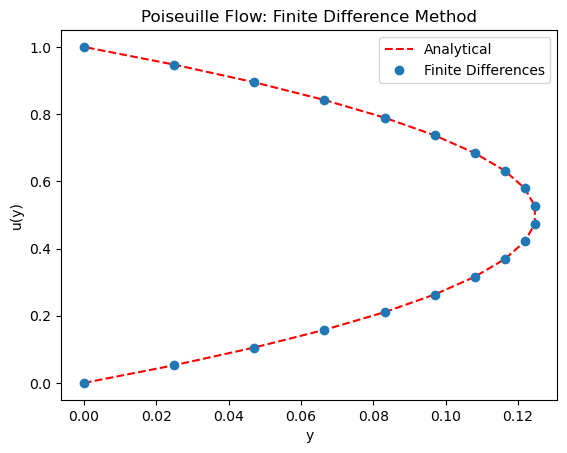

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 20          # Number of grid points
h_val = 1.0      # Domain [0, h]
mu = 1.0         # Viscosity coefficient
Pl = 1.0         # Pressure gradient

# Domain discretization
y = np.linspace(0, h_val, N)
dy = y[1] - y[0]

# Construct the finite difference matrix for u'' using central differences
A = np.zeros((N, N))
for i in range(1, N-1):
    A[i, i-1] = 1 / dy**2
    A[i, i]   = -2 / dy**2
    A[i, i+1] = 1 / dy**2

# Impose Dirichlet boundary conditions: u(0)=0 and u(h)=0
A[0, :] = 0
A[0, 0] = 1.0
A[-1, :] = 0
A[-1, -1] = 1.0

# Set up the right-hand side vector.
# For interior nodes, the equation is: u'' = -Pl/mu.
b = np.full(N, -Pl/mu)
# Enforce boundary conditions in the right-hand side
b[0] = 0
b[-1] = 0

# Solve the linear system A u = b
u_numerical = np.linalg.solve(A, b)

# Compute the analytical solution for comparison:
u_analytical = (-Pl / (2 * mu)) * y**2 + (Pl / (2 * mu)) * h_val * y

# Plot the results
plt.figure()
plt.plot(u_analytical,y, 'r--', label='Analytical')
plt.plot(u_numerical,y, 'o', label='Finite Differences')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Poiseuille Flow: Finite Difference Method')
plt.legend()
plt.show()


#### Structure of the Finite-Difference System (After Applying Boundary Conditions)

The discretized system for the Poiseuille flow problem is given by

$$
A\mathbf{u} = \mathbf{f},
$$

where the unknown vector is

$$
\mathbf{u} = \begin{pmatrix} u_0 \\ u_1 \\ \vdots \\ u_{N-1} \\ u_N \end{pmatrix}.
$$

The matrix \( A \) has the following structure after enforcing the Dirichlet boundary conditions:

$$
A = \begin{pmatrix}
1 & 0 & \cdots & 0 \\
\frac{1}{\Delta y^2} & -\frac{2}{\Delta y^2} & \frac{1}{\Delta y^2} & \cdots \\
\vdots & \vdots & \vdots & \ddots \\
0 & \cdots & \frac{1}{\Delta y^2} & -\frac{2}{\Delta y^2} & \frac{1}{\Delta y^2} \\
0 & \cdots & 0 & 0 & 1
\end{pmatrix}.
$$

The interior rows use the central difference approximation for the second derivative:

$$
u_{yy}(y_i) \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta y^2}, \quad i=1,2,\dots,N-1.
$$

Finally, the right-hand side vector $\mathbf{f}$ is initially defined for the interior nodes as

$$
f_i = -\frac{P_l}{\mu} \quad \text{for } i=1,2,\dots,N-1.
$$

To enforce the Dirichlet boundary conditions $ u_0 = 0$ and $ u_N = 0$, we must also **modify** (or "crush") the first and last elements of $ \mathbf{f} $ by setting:

$$
f_0 = 0 \quad \text{and} \quad f_N = 0.
$$

This ensures that both the system matrix $ A $ and the right-hand side vector $ \mathbf{f} $ correctly reflect the prescribed boundary conditions.


### Spectral Collocation using Chebyshev Polynomials for Poiseuille flow

In this section, we solve the same Poiseuille flow problem using spectral collocation with Chebyshev polynomials. The boundary value problem is

$$
0 = P_l + \mu \, u_{yy}, \quad u(0)=u(h)=0.
$$

The key ideas are:

1. **Chebyshev Collocation Points:**  
   We use Chebyshev–Gauss–Lobatto points, which are defined on the interval $[-1,1]$. They are given by
   $$
   x_j = \cos\left(\frac{\pi j}{N}\right), \quad j = 0,\ldots, N,
   $$
   and then mapped to the domain $y\in [0, h]$ via
   $$
   y = \frac{(x+1)h}{2}.
   $$

2. **Differentiation Matrix:**  
   A Chebyshev differentiation matrix $D$ is computed, and then scaled to account for the transformation from $[-1,1]$ to $[0,h]$. The second derivative matrix is obtained as:
   $$
   D_2 = \left(\frac{2}{h}\right)^2 D^2.
   $$

3. **Imposing Boundary Conditions:**  
   The rows corresponding to the endpoints (i.e., the degrees of freedom at the boundaries) are replaced to enforce the Dirichlet conditions $u(0)=0$ and $u(h)=0$.

4. **Solving the System:**  
   With the modified differentiation matrix and right-hand side $f = -P_l/\mu$ (from $u_{yy} = -P_l/\mu$), we solve the system to obtain the numerical solution. The analytical solution is again given by
   $$
   u(y) = \frac{P_l}{2\mu} y(h-y).
   $$

The Python code below implements these steps.


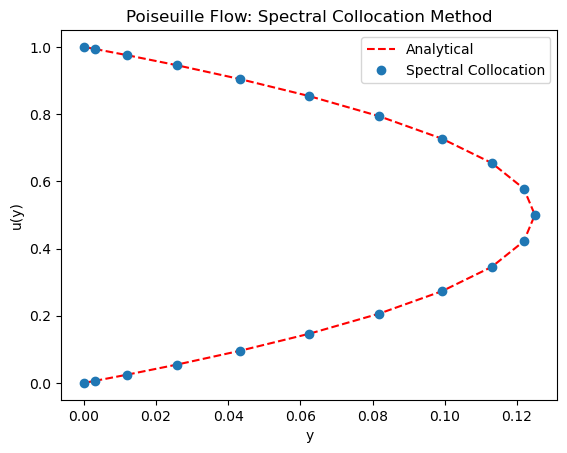

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def cheb(N):
    """
    Compute the Chebyshev differentiation matrix and nodes.
    
    Returns:
        D (ndarray): Chebyshev differentiation matrix (size (N+1) x (N+1)).
        x (ndarray): Chebyshev nodes in [-1, 1].
    """
    if N == 0:
        return np.array([[0]]), np.array([1.0])
    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.ones(N + 1)
    c[0] = 2
    c[-1] = 2
    c = c * ((-1) ** np.arange(N + 1))
    X = np.tile(x, (N + 1, 1))
    dX = X - X.T
    D = (np.outer(c, 1/c)) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D, axis=1))
    return D, x

# Parameters for the problem
N = 20         # Degree of the Chebyshev polynomial (number of collocation points minus one)
h_val = 1.0    # Domain: [0, h]
mu = 1.0       # Viscosity coefficient
Pl = 1.0       # Pressure gradient

# Compute Chebyshev differentiation matrix and nodes
D, x_cheb = cheb(N)

# Transform Chebyshev nodes from [-1, 1] to [0, h]
y = (x_cheb + 1) * h_val / 2

# Scale the differentiation matrix for the transformation:
# Since y = (x+1)*h/2, we have dy/dx = h/2 so that d/dy = (2/h)*d/dx.
D = 2/h_val * D
D2 = np.dot(D, D)  # Second derivative matrix

# Right-hand side of the differential equation: u'' = -Pl/mu
f = -Pl/mu * np.ones(N + 1)

# Impose Dirichlet boundary conditions: u(0)=0 and u(h)=0 by replacing the boundary rows.
D2[0, :] = 0
D2[0, 0] = 1.0
D2[-1, :] = 0
D2[-1, -1] = 1.0
f[0] = 0
f[-1] = 0

# Solve the system: mu * u'' = -Pl  ==>  u'' = -Pl/mu
u_numerical = np.linalg.solve(mu * D2, f)

# Compute the analytical solution for comparison:
u_analytical = (-Pl / (2 * mu)) * y**2 + (Pl / (2 * mu)) * h_val * y

# Plot the results
plt.figure()
plt.plot(u_analytical,y, 'r--', label='Analytical')
plt.plot(u_numerical,y, 'o', label='Spectral Collocation')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Poiseuille Flow: Spectral Collocation Method')
plt.legend()
plt.show()


#### Comparison of Sparsity Patterns

When setting up the linear systems prior to solving, the two methods lead to very different matrix structures:

- **Finite Differences:**  
  The finite-difference method discretizes the second derivative using central differences. This produces a **sparse** matrix where nonzero elements are mostly confined to the main diagonal and the first sub- and super-diagonals (i.e., a tridiagonal pattern). The only exceptions occur in the rows modified to enforce Dirichlet boundary conditions.

- **Spectral Collocation (Chebyshev):**  
  In contrast, the spectral collocation method using Chebyshev polynomials results in a **dense** differentiation matrix. The global nature of Chebyshev polynomials causes nearly every element of the second derivative matrix to be nonzero—even after modifying the boundary rows to impose the Dirichlet conditions.

This difference means that finite-difference systems are usually cheaper to store and solve due to their sparsity, while spectral methods, although yielding dense matrices, can offer higher accuracy for smooth problems.


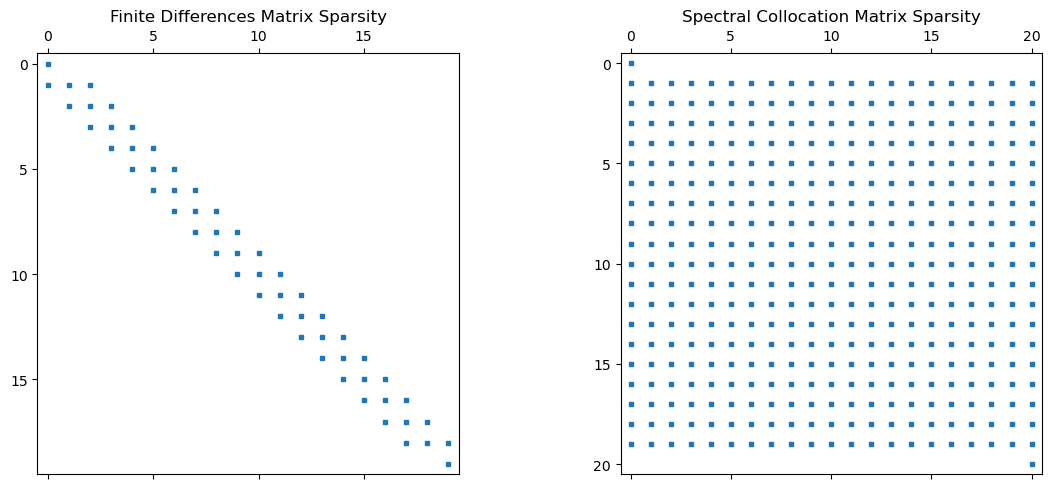

In [3]:
# Plot the sparsity patterns
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.spy(A, markersize=3)
plt.title('Finite Differences Matrix Sparsity')

plt.subplot(1,2,2)
plt.spy(D2, markersize=3)
plt.title('Spectral Collocation Matrix Sparsity')

plt.tight_layout()
plt.show()

Note how the first and last rows are modified so they effectively enforce the Dirichlet boundary conditions $u(0) = u(h) = 0$.

### Built-in BVP solver (SciPy)

We can solve the boundary value problem

$$
\mu u'' = -P_l,\quad u(0)=0,\quad u(h)=0,
$$

by converting it into a first-order system. Define

$$
u_1 = u,\quad u_2 = u',
$$

so that the system becomes

$$
u_1' = u_2,\quad u_2' = -\frac{P_l}{\mu}.
$$

The boundary conditions translate to

$$
u_1(0)=0,\quad u_1(h)=0.
$$


Using SciPy's `solve_bvp` function, we set up this system and its boundary conditions, provide an initial guess for the solution, and then solve for \(u(y)\). The resulting solution is then plotted for visualization.

> SciPy’s `solve_bvp` function uses a collocation method with adaptive mesh refinement to solve two-point boundary value problems. More about SciPy's bvp solver on the [scipy.integrate.solve_bvp Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html)



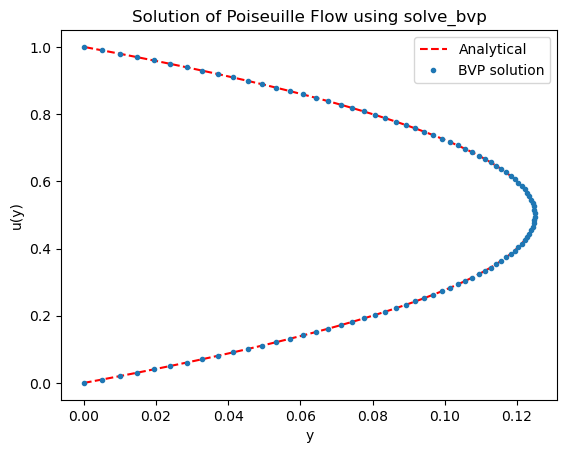

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Problem parameters
Pl = 1.0      # Pressure gradient
mu = 1.0      # Viscosity
h_val = 1.0   # Domain [0, h]

# Tolerance settings (adjust these to experiment with the solver's accuracy)
tol_value = 1e-6      # Solver tolerance; try different values (e.g., 1e-3, 1e-5)

# Define the system of first-order ODEs:
# u[0] = u, u[1] = u'
def fun(y, u):
    return np.vstack((u[1], -Pl/mu * np.ones_like(y)))

# Define the boundary conditions: u(0)=0 and u(h)=0
def bc(ua, ub):
    return np.array([ua[0], ub[0]])

# Create an initial mesh
y_mesh = np.linspace(0, h_val, 50)

# Provide an initial guess for u: both u and u' are initially zero
u_guess = np.zeros((2, y_mesh.size))

# Solve the boundary value problem with the specified tolerance and maximum nodes
sol = solve_bvp(fun, bc, y_mesh, u_guess, tol=tol_value)

# Evaluate the solution on a finer mesh
y_plot = np.linspace(0, h_val, 100)
u_plot = sol.sol(y_plot)[0]

#Analytical solution for visual comparison:
u_analytical = (-Pl / (2 * mu)) * y_plot**2 + (Pl / (2 * mu)) * h_val * y_plot

# Plot the solution
plt.figure()
plt.plot(u_analytical,y_plot, 'r--', label='Analytical')
plt.plot(u_plot, y_plot,'.', label=f'BVP solution')
plt.xlabel('y')
plt.ylabel('u(y)')
plt.title('Solution of Poiseuille Flow using solve_bvp')
plt.legend()
plt.show()


Observe how the built-in solver clusters nodes in regions where the gradient is steepest. While this bvp solver is both convenient and 
straightforward to implement, it can be seen as an overkill for solving such a simple problem.


### Another linear example: hydrodynamic journal bearings (infinitely-long limit)

We consider the dimensionless excess pressure $\Pi(\theta)$ in an infinitely long hydrodynamic journal bearing. The governing equation is

$$
\frac{d}{d\theta}\Bigl(\eta^3\,\frac{d\Pi}{d\theta}-\eta\Bigr)=0,\quad 0<\theta<2\pi,
$$

with the film profile $\eta=1-\epsilon\cos\theta$, and periodic boundary conditions $\Pi(0)=\Pi(2\pi)=0$.

Introducing 
$$
y_0=\Pi,\quad y_1=\frac{d\Pi}{d\theta},
$$
we obtain the first-order system

\begin{align}
& y_0'=y_1, \\
& y_1'=\frac{\eta'(\theta)}{\eta^3}\Bigl(1-3\eta^2\,y_1\Bigr),\quad\text{with}\quad \eta'(\theta)=\epsilon\sin\theta.
\end{align}

The analytical (Sommerfeld) solution is given by

$$
\Pi(\theta)=-\frac{\epsilon\,\sin\theta\,(2-\epsilon\cos\theta)}{(2+\epsilon^2)(1-\epsilon\cos\theta)^2}.
$$

Below is the Python implementation that solves this BVP and compares the numerical solution with the Sommerfeld solution for several values of $\epsilon$. 


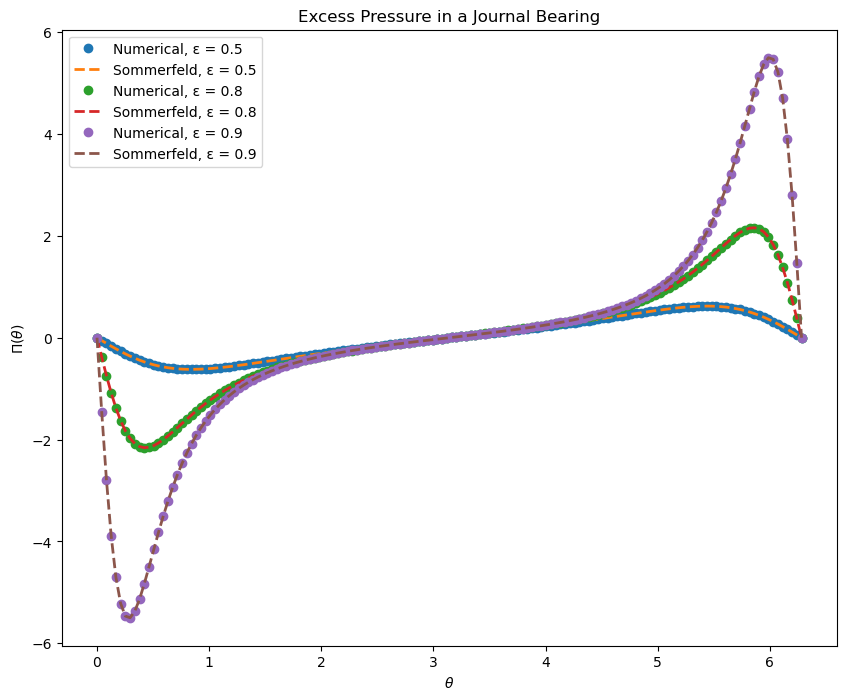

In [5]:
eps_values = [0.5, 0.8, 0.9]
theta_plot = np.linspace(0, 2*np.pi, 150)

plt.figure(figsize=(10, 8))
for eps in eps_values:
    # Define eta and its derivative for the current epsilon.
    def eta(theta):
        return 1 - eps * np.cos(theta)
    
    def eta_prime(theta):
        return eps * np.sin(theta)
    
    # ODE system: y[0] = Pi, y[1] = Pi'
    def fun(theta, y):
        dy0 = y[1]
        dy1 = (eta_prime(theta) / (eta(theta)**3)) * (1 - 3 * (eta(theta)**2) * y[1])
        return np.vstack((dy0, dy1))
    
    # Periodic boundary conditions: Pi(0)=Pi(2pi)=0
    def bc(ya, yb):
        return np.array([ya[0], yb[0]])
    
    theta_mesh = np.linspace(0, 2*np.pi, 200)
    y_guess = np.zeros((2, theta_mesh.size))
    
    sol = solve_bvp(fun, bc, theta_mesh, y_guess, tol=1e-4)
    if sol.status != 0:
        print(f"Warning: The BVP solver did not converge for eps = {eps}!")
    
    Pi_num = sol.sol(theta_plot)[0]
    Pi_sommerfeld = - (eps * np.sin(theta_plot) * (2 - eps*np.cos(theta_plot))) / ((2 + eps**2) * (1 - eps*np.cos(theta_plot))**2)
    
    plt.plot(theta_plot, Pi_num, 'o', lw=2, label=f'Numerical, ε = {eps}')
    plt.plot(theta_plot, Pi_sommerfeld, '--', lw=2, label=f'Sommerfeld, ε = {eps}')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\Pi(\theta)$')
plt.title('Excess Pressure in a Journal Bearing')
plt.legend()
# plt.grid(True)
plt.show()


Just for fun, let's plot the pressure distribution along a cylinder with arbitrary radius:

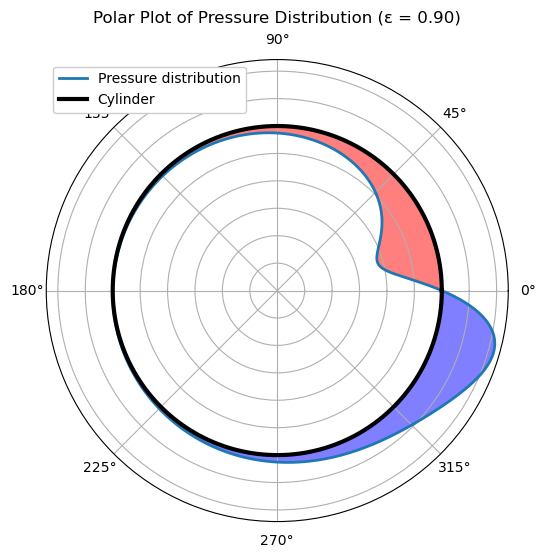

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Use the Sommerfeld solution for ε = 0.9
eps = 0.90
theta = np.linspace(0, 2*np.pi, 400)
Pi = - (eps * np.sin(theta) * (2 - eps*np.cos(theta))) / ((2 + eps**2) * (1 - eps*np.cos(theta))**2)

# Define an arbitrary base radius and a scaling factor to exaggerate the pressure variations
R0 = 6.0
scale = 0.4  # Adjust this factor as needed
r = R0 + scale * Pi

plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, lw=2, label='Pressure distribution')
ax.plot(theta, np.full_like(theta, R0), 'k-', lw=3, label='Cylinder')

# Fill the region above the cylinder (r >= R0) with red and below (r < R0) with blue.
ax.fill_between(theta, r, R0, where=(r >= R0), facecolor='blue', alpha=0.5)
ax.fill_between(theta, r, R0, where=(r < R0), facecolor='red', alpha=0.5)

ax.set_title(rf"Polar Plot of Pressure Distribution (ε = {eps:.2f})", va='bottom')
leg = ax.legend(loc='upper left')
leg.get_frame().set_alpha(1.0)
ax.set_yticklabels([])

plt.show()


## 2. Non-linear problems

### Blasius Boundary Layer with SciPy's `solve_bvp`

The Blasius boundary-layer equation is a classical nonlinear problem for a streamfunction $f = f(\eta)$ across a boundary layer with oncoming uniform velocity given by

$$
f''' + \frac{1}{2} f f'' = 0,
$$

with the boundary conditions

$$
f(0) = 0,\quad f'(0) = 0,\quad f'(\eta_\infty) = 1.
$$

To solve this using SciPy's built-in BVP solver, we first recast the third-order ODE into a system of first-order equations. Define

$$
y_1 = f,\quad y_2 = f',\quad y_3 = f'',
$$

so that the system becomes

$$
y_1' = y_2,\quad y_2' = y_3,\quad y_3' = -\frac{1}{2} y_1\, y_3.
$$

The boundary conditions are then expressed as

$$
y_1(0) = 0,\quad y_2(0) = 0,\quad y_2(\eta_\infty) = 1.
$$

In the code below, we choose a sufficiently large $\eta_\infty$ (e.g., 10) to approximate the condition at infinity and solve the problem using `solve_bvp`.


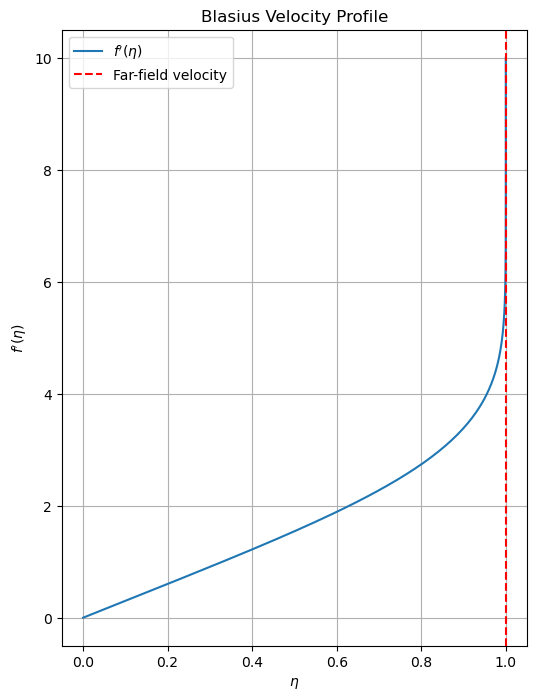

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Problem parameters
eta_max = 10.0       # A sufficiently large value to approximate infinity
tol_value = 1e-4     # Solver tolerance

# Define the system of ODEs.
# Let y[0] = f, y[1] = f', y[2] = f''.
def fun(eta, y):
    return np.vstack((y[1], y[2], -0.5 * y[0] * y[2]))

# Define the boundary conditions:
# At eta = 0: f(0)=0 and f'(0)=0.
# At eta = eta_max: f'(eta_max)=1.
def bc(ya, yb):
    return np.array([ya[0], ya[1], yb[1] - 1.0])

# Initial mesh for eta
eta_mesh = np.linspace(0, eta_max, 100)

# Initial guess for the solution.
# We provide an initial guess for f, f', and f''.
y_guess = np.zeros((3, eta_mesh.size))
y_guess[1] = np.linspace(0, 1, eta_mesh.size)  # Linear guess for f' from 0 to 1.

# Solve the BVP
sol = solve_bvp(fun, bc, eta_mesh, y_guess, tol=tol_value)

# Evaluate the solution on a finer mesh for plotting.
eta_plot = np.linspace(0, eta_max, 200)
f_plot   = sol.sol(eta_plot)[0]
fp_plot  = sol.sol(eta_plot)[1]


plt.figure(figsize=(6,8))
plt.plot(fp_plot, eta_plot, label="$f'(\\eta)$")
plt.axvline(1, color='red', linestyle='--', label="Far-field velocity")
plt.xlabel("$\\eta$")
plt.ylabel("$f'(\\eta)$")
plt.title("Blasius Velocity Profile")
plt.legend()
plt.grid(True)
plt.show()